### 라이브러리 설치

In [1]:
# 라이브러리 설치
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import optuna
import warnings
warnings.filterwarnings('ignore')

# Rgression Libraries
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import root_mean_squared_error, r2_score

%matplotlib inline

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

train = pd.read_csv('data/train.csv', index_col='ID')
test = pd.read_csv('data/test.csv', index_col='ID')
sub = pd.read_csv('data/sample_submission.csv')

<Axes: xlabel='Income', ylabel='Count'>

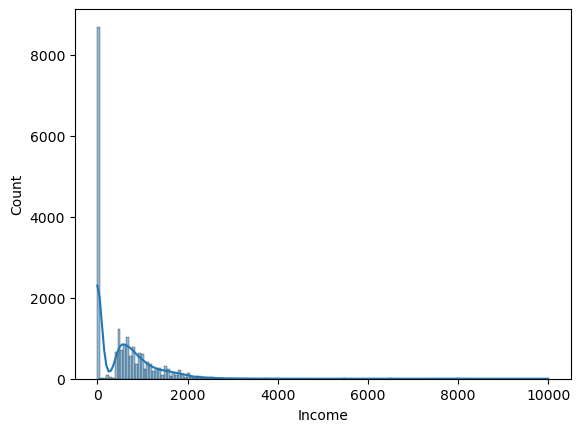

In [2]:
# 타겟 밸류인 인컴 확인
sns.histplot(train['Income'], kde=True)

### 이상치 제거

In [3]:
# 이상치 제거
idx = train[(train['Income'] >= 5000) & (train['Income'] < 10000) & (train['Income_Status'] == 'Under Median')].index
train.drop(idx, axis=0, inplace=True)

In [4]:
# 이상치 제거
train.loc[(train['Gains'] == 99999), 'Gains'] = 0

### 파생변수 생성
- 이민자 여부 (아버지를 중점으로)
- 투자와 관련된 값들이 이상치가 너무 높아 간단한 수학 공식을 적용해보았습니다.
$$df['Total Income indicator'] = \frac{df['Total Income indicator']}{||df['Tatal Income indicator']||_2}$$

In [5]:
def make_derived(df):
    
#     df['Gains'] = np.log1p(df['Gains'])
#     df['Losses'] = np.log1p(df['Losses'])
#     df['Dividends'] = np.log1p(df['Dividends'])
#     df['Industry_Occupation'] = df['Industry_Status'] + " - " + df['Occupation_Status']
    
    df['Immigrant_Background'] = np.where((df['Birth_Country'] == 'US') &
                                        (df['Birth_Country (Father)'] == 'US'), 'Native', 'Immigrant')
    
    df['Total Income indicator'] = (df['Gains'] - df['Losses'] + df['Dividends'])
    df['Total Income indicator'] = (df['Total Income indicator']) / np.sqrt(np.sum(df['Total Income indicator']**2))
    
    return df

make_derived(train)
make_derived(test)

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,...,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Immigrant_Background,Total Income indicator
ID,,,,,,,,,,,,,,,,,,,,,
TEST_0000,79,M,High Junior,Children or Armed Forces,0,Not in universe or children,Unknown,White,All other,Single,...,US,Unknown,Unknown,Single,0,0,0,Under Median,Immigrant,0.0
TEST_0001,47,M,Elementary (5-6),Children or Armed Forces,0,Not in universe or children,Unknown,White,Other Spanish,Single,...,US,US,US,Nonfiler,0,0,0,Under Median,Native,0.0
TEST_0002,18,F,High Junior,Children or Armed Forces,52,Retail,Services,White,All other,Single,...,US,US,US,Single,0,0,0,Under Median,Native,0.0
TEST_0003,39,F,Associates degree (Vocational),Full-Time,30,Medical (except Hospitals),Services,White,All other,Married,...,US,US,US,Married Filling Jointly both under 65 (MFJ),0,0,0,Unknown,Native,0.0
TEST_0004,6,M,Children,Children or Armed Forces,0,Not in universe or children,Unknown,White,Mexican-American,Single,...,US,US,US,Nonfiler,0,0,0,Unknown,Native,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEST_9995,31,M,Bachelors degree,Children or Armed Forces,52,Other professional services,Technicians & Support,White,All other,Single,...,US,US,US,Single,0,0,0,Under Median,Native,0.0
TEST_9996,27,M,College,Children or Armed Forces,52,Retail,Handlers/Cleaners,White,All other,Married,...,US,US,US,Married Filling Jointly both under 65 (MFJ),0,0,0,Under Median,Native,0.0
TEST_9997,18,M,High graduate,Children or Armed Forces,7,Retail,Services,Black,All other,Single,...,US,US,US,Nonfiler,0,0,0,Under Median,Native,0.0


### 이상치 제거 2

In [6]:
train[(train['Income_Status'] == 'Unknown')]['Income'].describe()

count    6026.000000
mean      545.810820
std       675.573189
min         0.000000
25%         0.000000
50%       475.000000
75%       876.750000
max      9400.000000
Name: Income, dtype: float64

In [7]:
ov_idx = train[train['Income'] > 7500].index

In [8]:
train.drop(ov_idx, axis=0, inplace=True)

In [9]:
train = train.drop(['Losses', 
                    'Birth_Country (Father)', 'Birth_Country (Mother)'], axis=1)
test = test.drop(['Losses',
                  'Birth_Country (Father)', 'Birth_Country (Mother)'], axis=1)

In [10]:
# test의 결측값에 결측값이 있어 최빈값으로 대체해주었습니다.
test['Household_Status'].fillna(test['Household_Status'].mode()[0], inplace=True)

In [11]:
obj_cols = train.select_dtypes('object').columns.tolist()

In [12]:
# for i in obj_cols:
#     le = LabelEncoder()
#     le = le.fit(train[i])
#     train[i] = le.transform(train[i])
    
#     # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
#     # test 데이터에 대해서 직접적으로 fit을 수행할 경우 Data Leakage
#     for case in np.unique(test[i]):
#         if case not in le.classes_: 
#             le.classes_ = np.append(le.classes_, case) 
    
#     test[i] = le.transform(test[i])

In [13]:
# 라벨 인코딩
for i in obj_cols:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])
    test[i] = le.transform(test[i])

In [14]:
# reset index
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [15]:
# train, validatoin data sets split
X = train.drop('Income', axis=1).copy()
y = train['Income'].copy()

X_tr, X_val, y_tr, y_val = train_test_split(X, y,
                                           test_size=0.3,
                                           random_state=42)

X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((13972, 20), (5989, 20), (13972,), (5989,))

In [16]:
# generate base model 
cat = CatBoostRegressor(random_state=42,
                       verbose=500,
                       cat_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])

xgb = XGBRegressor(random_state=42,
                  n_jobs=-1)

hgb = HistGradientBoostingRegressor(random_state=42,
                                   categorical_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])

models = [cat, xgb, hgb]
scores_train = []
scores_of_r2_train = []
scores_of_r2_test = []
for idx, model in enumerate(models):
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_val)
    
    train_r2 = r2_score(y_tr, y_pred_train)
    test_r2 = r2_score(y_val, y_pred_test)
    
    scores_of_r2_train.append(train_r2)
    scores_of_r2_test.append(test_r2)
    
    rmse = root_mean_squared_error(y_val, y_pred_test)
    scores_train.append(rmse)

Learning rate set to 0.062106
0:	learn: 624.0974682	total: 68.8ms	remaining: 1m 8s
500:	learn: 474.8837021	total: 4.82s	remaining: 4.8s
999:	learn: 454.0321060	total: 12.5s	remaining: 0us


In [17]:
scores_train

[495.5752844927955, 519.942527675697, 495.649968117602]

In [18]:
# Crossvalidation (base model)
scores = cross_val_score(estimator=cat,
                        X=X, y=y,
                        scoring='neg_root_mean_squared_error',
                        cv=10,
                        n_jobs=-1)
-scores.mean()

Learning rate set to 0.064621
0:	learn: 622.9928733	total: 132ms	remaining: 2m 11s
Learning rate set to 0.064622
Learning rate set to 0.064622
Learning rate set to 0.064622
Learning rate set to 0.064622
Learning rate set to 0.064622
Learning rate set to 0.064622
Learning rate set to 0.064622
0:	learn: 616.0346179	total: 94ms	remaining: 1m 33s
0:	learn: 621.5090269	total: 122ms	remaining: 2m 1s
0:	learn: 614.6033778	total: 133ms	remaining: 2m 12s
0:	learn: 623.0617535	total: 134ms	remaining: 2m 13s
0:	learn: 616.0116227	total: 167ms	remaining: 2m 46s
0:	learn: 617.4153752	total: 202ms	remaining: 3m 21s
0:	learn: 622.3352902	total: 192ms	remaining: 3m 11s
500:	learn: 481.0191495	total: 1m 5s	remaining: 1m 5s
500:	learn: 474.5346921	total: 1m 6s	remaining: 1m 5s
500:	learn: 476.6307127	total: 1m 6s	remaining: 1m 6s
500:	learn: 471.0526073	total: 1m 6s	remaining: 1m 6s
500:	learn: 473.8090334	total: 1m 6s	remaining: 1m 6s
500:	learn: 478.8222079	total: 1m 7s	remaining: 1m 6s
500:	learn: 47

503.79560139196485

In [19]:
# First hypter parameters tuning
cat_params = {'learning_rate': 0.01847725211377579, 
              'depth': 8, 
              'subsample': 0.5337968843170635, 
              'colsample_bylevel': 0.268973976327973, 
              'min_data_in_leaf': 99,
             'iterations': 1000,
             'verbose':500,
             'cat_features':[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18]}

xgb_params = {'learning_rate': 0.016838742164370216, 
              'depth': 3, 
              'subsample': 0.8666720048612185, 
              'colsample_bytree': 0.18688459705364951, 
              'gamma': 20, 'n_estimators': 641, 
              'min_child_weight': 0.3509849473293521}

hgb_params = {'max_leaf_nodes': 19, 
              'learning_rate': 0.049120475865009075, 
              'max_depth': 18, 
              'min_samples_leaf': 38}

In [20]:
# First model
cat = CatBoostRegressor(**cat_params)
xgb = XGBRegressor(**xgb_params,
                  n_jobs=-1)
hgb = HistGradientBoostingRegressor(**hgb_params,
                                   categorical_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])

models = [cat, xgb, hgb]
scores_train = []
scores_of_r2_train = []
scores_of_r2_test = []
for idx, model in enumerate(models):
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_val)
    
    train_r2 = r2_score(y_tr, y_pred_train)
    test_r2 = r2_score(y_val, y_pred_test)
    
    scores_of_r2_train.append((model.__module__, train_r2))
    scores_of_r2_test.append((model.__module__, test_r2))
    
    rmse = root_mean_squared_error(y_val, y_pred_test)
    scores_train.append((model.__module__, rmse))

0:	learn: 631.9606412	total: 18ms	remaining: 18s
500:	learn: 483.4934940	total: 6.44s	remaining: 6.42s
999:	learn: 461.5968942	total: 13.8s	remaining: 0us


In [21]:
scores_train

[('catboost.core', 494.26280486981096),
 ('xgboost.sklearn', 497.6534601501762),
 ('sklearn.ensemble._hist_gradient_boosting.gradient_boosting',
  494.1638812432803)]

In [22]:
# Second params models
cat_params = {'learning_rate': 0.01847725211377579, 
              'depth': 8, 
              'subsample': 0.5337968843170635, 
              'colsample_bylevel': 0.268973976327973, 
              'min_data_in_leaf': 99,
             'iterations': 1000,
             'verbose':500,
             'cat_features':[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18]}

xgb_params = {'learning_rate': 0.016838742164370216, 
              'subsample': 0.8666720048612185, 
              'colsample_bytree': 0.18688459705364951, 
              'gamma': 20, 'n_estimators': 641, 
              'min_child_weight': 0.3509849473293521}

hgb_params = {'max_leaf_nodes': 19, 
              'learning_rate': 0.049120475865009075, 
              'max_depth': 18, 
              'min_samples_leaf': 38}

xgb_model = XGBRegressor(**xgb_params)
cat_model = CatBoostRegressor(**cat_params)
hgb_model = HistGradientBoostingRegressor(**hgb_params,
                                         categorical_features=[1, 2, 3, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14, 17, 18])

# Voiting ensemble
voting_regressor = VotingRegressor(estimators=[('catboost', cat_model),
                                  ('xgb', xgb_model),
                                  ('hgb', hgb_model)])

model = voting_regressor.fit(X_tr, y_tr)

0:	learn: 631.9606412	total: 20ms	remaining: 20s
500:	learn: 483.4934940	total: 6.74s	remaining: 6.71s
999:	learn: 461.5968942	total: 14s	remaining: 0us


In [23]:
# Crossvalidate for Final model
scores = cross_val_score(estimator=model,
                        X=X, y=y,
                        scoring='neg_root_mean_squared_error',
                        cv=10,
                        n_jobs=-1)

-scores.mean()

0:	learn: 631.1021527	total: 102ms	remaining: 1m 42s
0:	learn: 624.1963750	total: 94.6ms	remaining: 1m 34s
0:	learn: 629.0205043	total: 118ms	remaining: 1m 57s
0:	learn: 625.5719094	total: 133ms	remaining: 2m 12s
0:	learn: 623.6045873	total: 133ms	remaining: 2m 12s
0:	learn: 629.6666431	total: 108ms	remaining: 1m 47s
0:	learn: 621.9235106	total: 142ms	remaining: 2m 21s
0:	learn: 631.3748272	total: 150ms	remaining: 2m 30s
500:	learn: 483.1248503	total: 50.3s	remaining: 50.1s
500:	learn: 488.2506699	total: 50.3s	remaining: 50.1s
500:	learn: 486.4325104	total: 50.9s	remaining: 50.7s
500:	learn: 488.9236806	total: 51.3s	remaining: 51.1s
500:	learn: 483.5930401	total: 51.7s	remaining: 51.5s
500:	learn: 479.4415524	total: 52.2s	remaining: 52s
500:	learn: 485.5803063	total: 52.3s	remaining: 52s
500:	learn: 481.9480592	total: 52.4s	remaining: 52.2s
999:	learn: 465.6404768	total: 1m 46s	remaining: 0us
999:	learn: 471.6194830	total: 1m 47s	remaining: 0us
999:	learn: 470.3736923	total: 1m 47s	rem

503.24178932636744

In [24]:
# 모델 예측
pred = model.predict(test)

# 후처리 1  예측 값이 0보다 작은 값들을 0으로 처리.
pred = [0 if i < 0 else i for i in pred]
# 후처리 2 나이가 0인 사람들의 근로소득 값 0 으로 처리.
test['Income'] = pred
test.loc[test['Age'] == 0, 'Income'] = 0

In [25]:
y_result = test['Income'].values
sub['Income'] = y_result
sub.to_csv('data/sub_0408_1.csv', index=False)
df_sub = pd.read_csv('data/sub_0408_1.csv')